In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from matplotlib.colors import LogNorm
from scipy.interpolate import RectBivariateSpline

from copy import deepcopy

import quasiclassical_solver as qs
from legendre import *

In [2]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456
u2au = 1822.88839

# Potential

## Wojtek, interpolation

7 47
0.2164


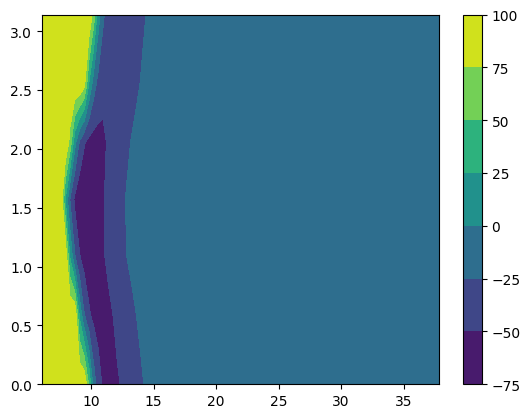

In [3]:
data = np.loadtxt( "../potentials/potential.dat" )


th_raw = np.array([0.0, 33.8783, 62.0404, 90.0, 117.96, 146.122, 180.0]) * np.pi / 180.

N_th = len(th_raw)
N_R = len( data ) // N_th

print( N_th, N_R )

R_raw = data[:N_R, 0]

PES_raw = np.reshape( data[:,1], (N_th, N_R) )


print( np.max( PES_raw ) )

PES_clip = np.clip(PES_raw * au2cm, -100, 100)
R_gr, th_gr = np.meshgrid( R_raw, th_raw )

plt.contourf( R_gr, th_gr, PES_clip )
plt.colorbar()

pass

/tmp/ipykernel_2437023/184471368.py:46: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf( R_ext, th_raw, np.abs(PES_ext) * au2cm, norm=LogNorm() )


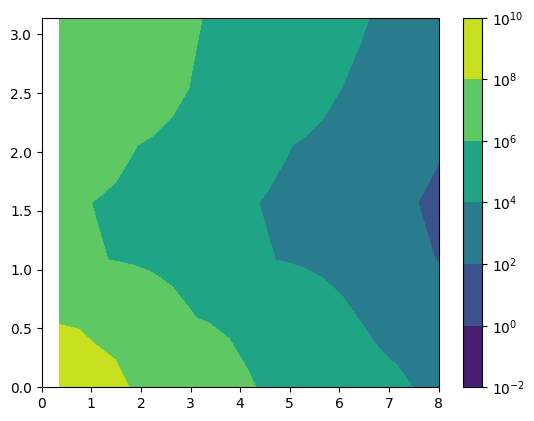

In [4]:
def extrapolate_to_zero(rs, V_values, max_val=1000):
    dr = rs[1] - rs[0]
    dVRatio = V_values[0] / V_values[1]
    dVRatio *= 1.005

    rs_extended = [rs[0] - dr]
    V_extended = [V_values[0] * dVRatio]

    dumping = 0
    while rs_extended[-1] > dr:
        if V_extended[-1] >= max_val:
            V_extended[-1] = max_val + 1000 * np.sqrt(dumping)
            dVRatio = 1
            dumping += 1
        else:
            dVRatio *= 1.005
        rs_extended.append(rs_extended[-1] - dr)
        V_extended.append(V_extended[-1] * dVRatio)

    rs_extended.reverse()
    V_extended.reverse()

    return rs_extended, V_extended

def extrapolate_to_infinity(rs, V_values, max_distance = 60):
    dr = rs[-1] - rs[-2]
    r_extended = [rs[-1] + dr]
    V_extended = [0.0]
    while(r_extended[-1] < max_distance):
        r_extended.append(r_extended[-1] + dr)
        V_extended.append(0.0)

    return r_extended, V_extended

PES_ext = [[]]*N_th

for i in range(N_th):
    R_ext_0, PES_ext_0 = extrapolate_to_zero(R_raw, PES_raw[i])
    R_ext_inf, PES_ext_inf = extrapolate_to_infinity(R_raw, PES_raw[i], max_distance = 50.)
    R_ext = R_ext_0 + list( R_raw ) + R_ext_inf
    PES_ext[i] = PES_ext_0 + list( PES_raw[i] ) + PES_ext_inf

R_ext = np.array( R_ext )
PES_ext = np.array( PES_ext )

plt.contourf( R_ext, th_raw, np.abs(PES_ext) * au2cm, norm=LogNorm() )

plt.xlim( 0, 8 )

plt.colorbar()

pass

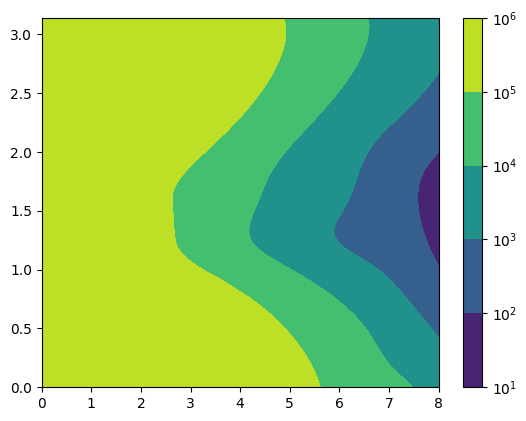

In [5]:
V_interp = RectBivariateSpline( th_raw, R_ext, PES_ext, kx=5, ky=5, s=0 )


force = V_interp.partial_derivative(0, 1)
force_vect = np.vectorize( lambda r, th: - force( th, r ) )

def potential( r, th ):
    return V_interp( th, r )

potential = np.vectorize( potential )


r_arr = np.linspace( 0, 8, 300 )
th_arr = np.linspace( 0, np.pi, 300 )


th_gr, r_gr = np.meshgrid( th_arr, r_arr )

PES_interp = potential( r_gr, th_gr )
PES_clip = np.clip(PES_interp * au2cm, 0, 1 * au2cm)

plt.contourf( r_gr, th_gr, np.abs(PES_clip), norm=LogNorm() )
plt.colorbar()


## empirical

In [6]:
import os

data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

CM_INV = 4.55633e-6
KELVIN = 3.1668105e-6
U = 1822.88839

def centrifugal(r_points, j_tot: int, omega: int, mass_u: float):
    return (j_tot * (j_tot + 1) - 2 * omega * omega) / (2 * mass_u * U * np.power(r_points, 2))

class Potential:
    def __init__(self, r_o, r_c, r_s, d6_o, d6_c, d6_s, re_o, re_c, re_s, alpha):
        self.r_o = r_o
        self.r_c = r_c
        self.r_s = r_s
        self.d6_o = d6_o
        self.d6_c = d6_c
        self.d6_s = d6_s
        self.re_o = re_o
        self.re_c = re_c
        self.re_s = re_s
        self.alpha = alpha
    
    @staticmethod
    def default():
        return Potential(3.1787, 0.9908, -1.957, 
                         1.09853700e-5, 2.35435928e-04, 7.63334226e-05, 
                         8.9643377e+00, 9.73677283e+00, 1.02445905e+01, 
                         1.23674328e+02 )

    def value(self, r, theta):

        r_o = np.sqrt(r**2 + self.r_o**2 - 2 * r * self.r_o * np.cos(theta))
        r_c = np.sqrt(r**2 + self.r_c**2 - 2 * r * self.r_c * np.cos(theta))
        r_s = np.sqrt(r**2 + self.r_s**2 - 2 * r * self.r_s * np.cos(theta))

        pot_o = self.d6_o * (self.re_o / r_o) ** 6 * ((self.re_o / r_o) ** 6 - 2)
        pot_c = self.d6_c * (self.re_c / r_c) ** 6 * ((self.re_c / r_c) ** 6 - 2)
        pot_s = self.d6_s * (self.re_s / r_s) ** 6 * ((self.re_s / r_s) ** 6 - 2)

        # cos_alpha = ( r * np.cos(theta) - self.r_c ) \
        #     / np.sqrt( r**2 + self.r_c**2 - 2 * r * self.r_c * np.cos( theta ) )
        pot_dip = -self.alpha * np.cos(theta) ** 2 / (r ** 6)

        return pot_o + pot_c + pot_s + pot_dip

(4.0, 20.0)

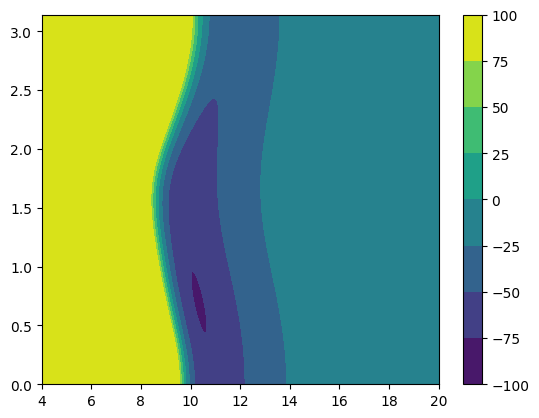

In [13]:

emp_fit = Potential.default()

r_arr = np.linspace( 4, 20, 300 )
th_arr = np.linspace( 0, np.pi, 300 )


th_gr, r_gr = np.meshgrid( th_arr, r_arr )

PES_interp = emp_fit.value( r_gr, th_gr )
PES_clip = np.clip(PES_interp * au2cm,-100, 100)

plt.contourf( r_gr, th_gr, PES_clip )
plt.colorbar()

plt.xlim( 4, 20 )

# plt.savefig( "PES_Ne_OCS_fit.png" )

In [16]:
import split_op as split
import numpy as np
from scipy.special import roots_legendre, lpmv
from tqdm import tqdm

from potential import load_potential
import os

data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

CM_INV = 4.55633e-6
KELVIN = 3.1668105e-6
U = 1822.88839
ANGS = 1.88973
DEB = 0.39343
EV = 0.03675
PM = 0.0188973
KCAL_MOL = 0.043 * EV

def centrifugal(r_points, j_tot: int, omega: int, mass_u: float):
    return (j_tot * (j_tot + 1) - 2 * omega * omega) / (2 * mass_u * U * np.power(r_points, 2))


def positions_from_center_mass(oc_bond: float, cs_bond: float) -> tuple[float, float, float]:
    mass_O = 15.999
    mass_C = 12.011
    mass_S = 32.06

    center_mass_from_O = (mass_O * oc_bond - mass_S * cs_bond) / (mass_O + mass_C + mass_S)

    return (oc_bond - center_mass_from_O, -center_mass_from_O, -cs_bond - center_mass_from_O)

def get_lennard_jones(eps_a, eps_b, half_r_a, half_r_b) -> tuple[float, float]:
    repulsive = np.sqrt(eps_a * eps_b) * (half_r_a + half_r_b) ** 12
    attractive = 2 * np.sqrt(eps_a * eps_b) * (half_r_a + half_r_b) ** 6

    return (repulsive, attractive)

class Potential:
    def __init__(self, r_o, r_c, r_s, rep_o, rep_c, rep_s, attr_o, attr_c, attr_s, alpha):
        self.r_o = r_o
        self.r_c = r_c
        self.r_s = r_s
        self.rep_o = rep_o
        self.rep_c = rep_c
        self.rep_s = rep_s
        self.attr_o = attr_o
        self.attr_c = attr_c
        self.attr_s = attr_s
        self.alpha = alpha

    @staticmethod
    def default():
        r_o, r_c, r_s = positions_from_center_mass(1.5710 * ANGS, 1.1526 * ANGS)
        
        eps_ne = -9.4352 * KCAL_MOL
        half_r_ne = 1.7727 * ANGS
        rep_o, attr_o = get_lennard_jones(-0.18 * KCAL_MOL, eps_ne, 1.79 * ANGS, half_r_ne)
        rep_c, attr_c = get_lennard_jones(-0.18 * KCAL_MOL, eps_ne, 1.87 * ANGS, half_r_ne)
        rep_s, attr_s = get_lennard_jones(-0.45 * KCAL_MOL, eps_ne, 2 * ANGS, half_r_ne)

        alpha = 0.7 * DEB * 27.8 * ANGS ** 3 / 2

        return Potential(r_o, r_c, r_s,
                         rep_o, rep_c, rep_s,
                         attr_o, attr_c, attr_s,
                         alpha)

    def value(self, r, theta):
        r_o = np.sqrt(r ** 2 + self.r_o ** 2 - 2 * r * self.r_o * np.cos(theta))
        r_c = np.sqrt(r ** 2 + self.r_c ** 2 - 2 * r * self.r_c * np.cos(theta))
        r_s = np.sqrt(r ** 2 + self.r_s ** 2 - 2 * r * self.r_s * np.cos(theta))
    
        pot_o = self.rep_o / r_o ** 12 - self.attr_o / r_o ** 6
        pot_c = self.rep_c / r_c ** 12 - self.attr_c / r_c ** 6
        pot_s = self.rep_s / r_s ** 12 - self.attr_s / r_s ** 6

        cos_theta_shifted = (r * np.cos(theta) - self.r_c) / r_c

        pot_dip = - self.alpha * (1 + 3 * cos_theta_shifted ** 2) / r_c ** 6

        return pot_o + pot_c + pot_s + pot_dip
    
emp_par = Potential.default()

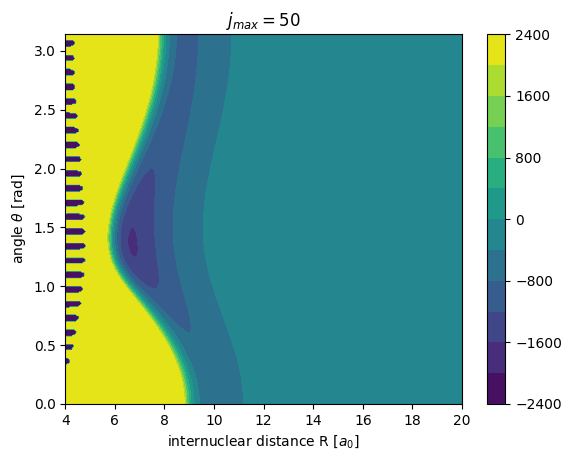

In [17]:
from scipy.special import lpmv

def get_legendre_decomp( fun, j_max, N_integral = 1000 ):

    x, w = np.polynomial.legendre.leggauss( N_integral )
    x = -x
    th = np.arccos( x )

    coeff = [0.]*(j_max + 1)

    for j in range( j_max + 1 ):
        coeff[j] = np.sum( fun( th ) * lpmv(0, j, x) * np.sqrt( j + 0.5 ) * w )

    return coeff

r_arr = np.reshape( np.linspace( 4, 20, 300 ), (-1,1) )

V_j_max = 50

j_arr = np.reshape( np.arange( V_j_max + 1 ), (1, -1) )

coeff_mat = np.zeros( (len( r_arr ), V_j_max + 1 ) )

for i, r in enumerate( r_arr ):
    coeff_mat[i, :] = get_legendre_decomp( lambda th: emp_par.value(r,th), V_j_max, N_integral=200 )

coeff_clip = np.clip( coeff_mat, -0.01, 0.01 ) * au2cm

# plt.pcolor( j_arr, r_arr, coeff_clip )

th_arr = np.reshape( np.linspace( 0, np.pi, 300 ), (1, -1) )
j_arr = np.reshape( np.arange( V_j_max + 1 ), (-1, 1) )

V_legendre = coeff_mat @ ( lpmv( 0, j_arr, np.cos( th_arr ) ) * np.sqrt( j_arr + 0.5 ) )
V_legendre = V_legendre.T

V_clip = np.clip( V_legendre, -0.01, 0.01 ) * au2cm

r_gr, th_gr = np.meshgrid( r_arr, th_arr )

plt.contourf( r_gr, th_gr, V_clip, levels = 10 )

plt.title( r"$j_{max} = $" + str(V_j_max) )

plt.xlabel( r"internuclear distance R [$a_0$]" )
plt.ylabel( r"angle $\theta$ [rad]" )

plt.colorbar()

# plt.savefig( f"PES_Ne_OCS_legendre_max_{V_j_max}.png" )

# plt.close()

pass

## test pot

In [9]:
def strong_anisotropic(r, th, C_12, C_6):
    return C_12 / r**12 - C_6 / r**6 * ( 1 + np.cos(th) + np.cos(th)**2 )

plt.contour

<function matplotlib.pyplot.contour(*args, data=None, **kwargs)>

# Simulation

In [10]:
solv = qs.Quasi_classic( m_rot = (16 + 32 + 12) * u2au, 
                        Be_rot = 0.20286/au2cm,#9.243165268327e-7, 
                        m_proj = 20 * u2au 
                        )

# simple_pot = lambda r, th: 2.5e7 / r**12 - 100/r**6 * ( 1 + 3 * np.cos( th )**2 + np.cos( th )**3 + np.cos( th )**10 )
solv.set_potential( emp_fit.value )
# solv.set_force( force_vect )

j_init = [0, 1]

solv_arr = []

for j in j_init:

        solv.set_hilbert_space( max_l=250, 
                        max_m = j
                        )

        solv.set_initial_conditions( E_col = 3700 * 3.1668105e-6, 
                                r_0 = 50.0, 
                                l_0 = j 
                                )

        solv.solve( t_max = 2 / au2ps,
                kwargs={"first_step": 1e3,
                        "atol": 1e-7, "rtol": 1e-5,
                        "t_eval": np.linspace( 1/au2ps, 1.5/au2ps, 1000 )}
                ) 

        print( f"j_init={j} finished" )
        solv_arr.append( deepcopy( solv ) )


pass

j_init=0 finished


KeyboardInterrupt: 

# Plotting

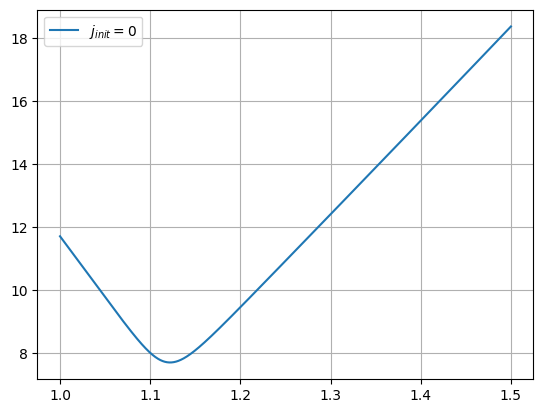

In [11]:
for j, solv in zip( j_init, solv_arr ):
    plt.plot( solv.t*au2ps, solv.r ,label = r"$j_{init} = $" + f"{j}" )

plt.legend()
plt.grid()

(1000, 251) (251,)


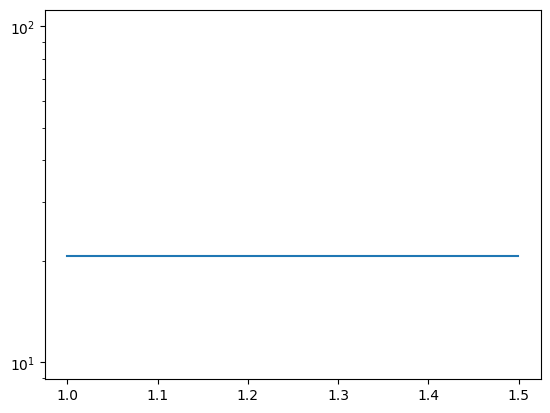

In [12]:
# plt.plot( solv.t[:-1] * au2ps ,  1. / np.diff( solv.t ) / au2ps / solv.N_t )
# plt.hist( solv.t * au2ps, bins = 101, density=True )

plt.plot( solv.t[:-1] * au2ps ,  np.diff( solv.t ) )

print( solv.Psi_ang.shape, solv.w_all.shape )
plt.semilogy()

pass

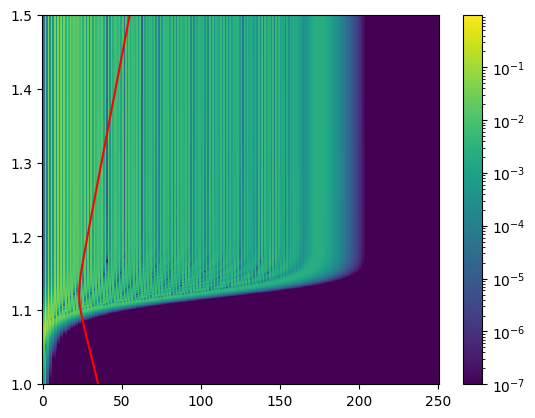

In [13]:
solv = solv_arr[0]

l_max = np.max( solv.l_arr )
rot_prob = np.zeros( (solv.N_t, l_max + 1) )

for i, l in enumerate( solv.l_arr ):
    rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2

# rot_prob = rot_prob / np.reshape( np.max( rot_prob, axis=1 ), (-1,1) )

plt.pcolor(np.arange( 0, l_max + 1 ), 
           solv.t*au2ps,           
           rot_prob, norm=LogNorm(vmin = 1e-7) )

plt.colorbar()

# plt.xlim( -0.5, 50 )

# plt.ylim( 1., 1.25 )

plt.plot( solv.r*3, solv.t*au2ps, 'r' )

pass

In [ ]:
solv = solv_arr[0]

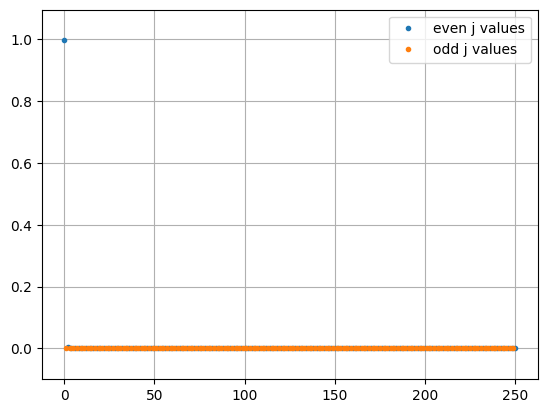

In [14]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

leg_even, = ax.plot( np.arange( 0, l_max + 1, 2 ), rot_prob[0,::2], '.', label = "even j values" )
leg_odd, = ax.plot( np.arange( 1, l_max + 1, 2 ), rot_prob[0,1::2], '.', label = "odd j values" )

ax.legend()
ax.grid()

def animate(i):

    t_ind = i*5

    leg_even.set_ydata(rot_prob[t_ind,::2])
    leg_odd.set_ydata(rot_prob[t_ind,1::2])

    max_p = np.max( rot_prob[t_ind] )

    ax.set_ylim( bottom = -0.1 * max_p, top = max_p * 1.1 )

    return leg_even, leg_odd, ax, 

ani = animation.FuncAnimation(fig, animate, repeat=False,
                                    frames=200, interval = 60 )

writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)

ani.save('scatter.gif', writer="pillow")

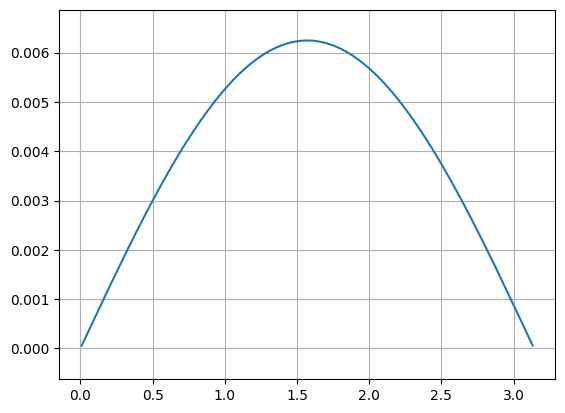

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

Psi, = ax.plot( solv.th_all, np.abs( solv.Psi_ang[0] )**2 * solv.w_all )

ax.grid()

def animate(i):

    t_ind = i

    Psi.set_ydata(np.abs( solv.Psi_ang[t_ind] )**2 * solv.w_all )

    max_p = np.max( np.abs( solv.Psi_ang[t_ind] )**2 * solv.w_all )

    ax.set_ylim( bottom = -0.1 * max_p, top = max_p * 1.1 )

    return Psi, ax, 

ani = animation.FuncAnimation(fig, animate, repeat=False,
                                    frames=500, interval = 60 )

writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)

ani.save('scatter_ang.gif', writer="pillow")

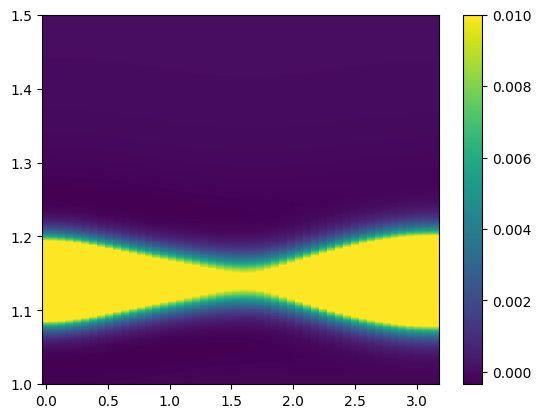

In [ ]:
th = np.linspace(0, np.pi)

th_gr, r_gr = np.meshgrid( th, solv.r )

V_time = emp_fit.value( r_gr, th_gr)

# V_time -= np.reshape( np.mean( V_time, axis = 1 ), (-1,1) )
V_time = np.clip( V_time, -100/au2cm, 0.01 )

plt.pcolor( th, solv.t * au2ps, V_time )

plt.colorbar()